# Time progression line charts

Note: Before this notebook is run, the `01_clean_data.py` needs to have been run. You can verify this by checking that a subdirectory named `data_cleaned` exists in this directory and contains a file named `data_cleaned.tsv`, and by checking for a subdirectory of the directory this notebook is in named `rnks` and containing GSEA-style `.rnk` files for 8 days: 2, 4, 14, 36, 40, 125, 130, and 250.

In [1]:
import altair as alt
import numpy as np
import os
import pandas as pd

import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()

intermed_dir = "intermediate_files"
input_file = os.path.join(intermed_dir, "data_cleaned.tsv")
output_dir = "output_charts"
os.makedirs(output_dir, exist_ok=True)

## Linechart for all genes across all days

In [2]:
df = pd.\
read_csv(input_file, sep="\t", index_col=0).\
assign(day_000_log2fc=0) # Add a value of 0 at day 0 for plotting ease 

# Make the columns actual numbers
df.columns = df.columns.to_series().str.split("_", expand=True)[1].astype(int)
df.columns.name = None

df_long = df.\
sort_index(axis="columns").\
reset_index(drop=False).\
melt(
    id_vars="HUGO",
    var_name="day",
    value_name="log2fc",
)

chart_all = alt.Chart(df_long).mark_line().encode(
    x="day",
    y="log2fc",
    color=alt.Color(
        "HUGO",
        legend=None,
    ),
)

chart_all.save(os.path.join(output_dir, "linecharts_all.html"))
chart_all

alt.Chart(...)

## Linechart for just SOX9

(SOX10 isn't present in these data)

In [3]:
df_sox = df_long[df_long.HUGO == "SOX9"]

chart_sox = alt.Chart(df_sox).mark_line().encode(
    x="day",
    y="log2fc",
    color="HUGO",
)

chart_sox

alt.Chart(...)

## Investigating whether to exclude day 39

There appears to be a weird outlier for many samples at day 39 on the line chart of all samples together--a blip up or down that's very discontinuous from the other days close by. Let's check some randomly sampled samples to make sure its apparent pervasiveness is actually there and not just an artifact of the line layering when the chart is drawn.

In [4]:
df_39 = df[df[36].notna() & df[39].notna() & df[40].notna()].\
sort_index(axis="columns").\
reset_index(drop=False).\
melt(
    id_vars="HUGO",
    var_name="day",
    value_name="log2fc",
)

chart_sel = alt.hconcat(*[alt.Chart(df_39[df_39.HUGO == gene]).mark_line().encode(
    x="day",
    y="log2fc",
    color="HUGO",
) for gene in df_39.HUGO.sample(20)])

chart_sel

alt.HConcatChart(...)

### Conclusion after looking at the charts:

Yeah this blip is common. We'll exclude day 39.

In [5]:
df = df.drop(columns=39)

Let's look at the linechart of all of them, without day 39 now.

In [6]:
df_long_no_39 = df.\
sort_index(axis="columns").\
reset_index(drop=False).\
melt(
    id_vars="HUGO",
    var_name="day",
    value_name="log2fc",
)

chart_no_39 = alt.Chart(df_long_no_39).mark_line().encode(
    x="day",
    y="log2fc",
    color=alt.Color(
        "HUGO",
        legend=None,
    ),
)

chart_no_39.save(os.path.join(output_dir, "linecharts_no_39.html"))
chart_no_39

alt.Chart(...)

# Clustering

Time series clustering will require interpolation of any NaNs, so first let's see how many genes even have measurements for all 8 days.

In [7]:
alt.Chart(df.isna().sum(axis=1).rename("na_ct").to_frame()).mark_bar().encode(
    x="na_ct",
    y="count()",
)

alt.Chart(...)

And let's see which days have the NaNs:

In [8]:
df.isna().sum(axis=0)

2      1079
4      1318
14     1198
36     1686
40     1612
125    3746
130    5284
250    5301
0         0
dtype: int64

Hmm not so great. But what if we just look at the first 5 timepoints that are closer together and have less NaNs? 

In [9]:
alt.Chart(df[[2, 4, 14, 36, 40]].isna().sum(axis=1).rename("na_ct").to_frame()).mark_bar().encode(
    x="na_ct",
    y="count()",
)

alt.Chart(...)

That's more manageable. We'll just look at the genes that have no NaNs for the first 5 days. In the future we can do interpolation if we want for those that are only missing a few points.

In [10]:
df_5_timepoints = df[[2, 4, 14, 36, 40]]
df_no_nans = df_5_timepoints[df_5_timepoints.notna().all(axis=1)]

On to clustering. Adapted from https://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas

For options for `method` parameter, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

For options for `metric` parameter, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

The other thing to experiment with changing is `num_clusters`.

In [11]:
Z = hac.linkage(df_no_nans, method="weighted", metric="euclidean")
num_clusters = 4
results = pd.Series(fcluster(Z, t=num_clusters, criterion="maxclust"))

charts = []
for c in results.unique():
    cluster_indices = results[results == c].index
    print(len(cluster_indices))
    cluster = df_no_nans.iloc[cluster_indices, :]
    
    cluster = cluster.\
    assign(**{"0": 0})
    
    cluster.columns = cluster.columns.astype(int)
    
    cluster = cluster.\
    reset_index(drop=False).\
    melt(
        id_vars="HUGO",
        var_name="day",
        value_name="log2fc",
    )

    cluster_chart = alt.Chart(cluster).mark_line().encode(
        x="day",
        y="log2fc",
        color=alt.Color(
            "HUGO",
            legend=None,
        ),
        tooltip=["HUGO"],
    )
    
    charts.append(cluster_chart)

cluster_linecharts = alt.hconcat(*charts).resolve_scale(
    y="shared"
)

cluster_linecharts.save(os.path.join(output_dir, "cluster_linecharts.html"))
cluster_linecharts

2206
1579
5
10


alt.HConcatChart(...)

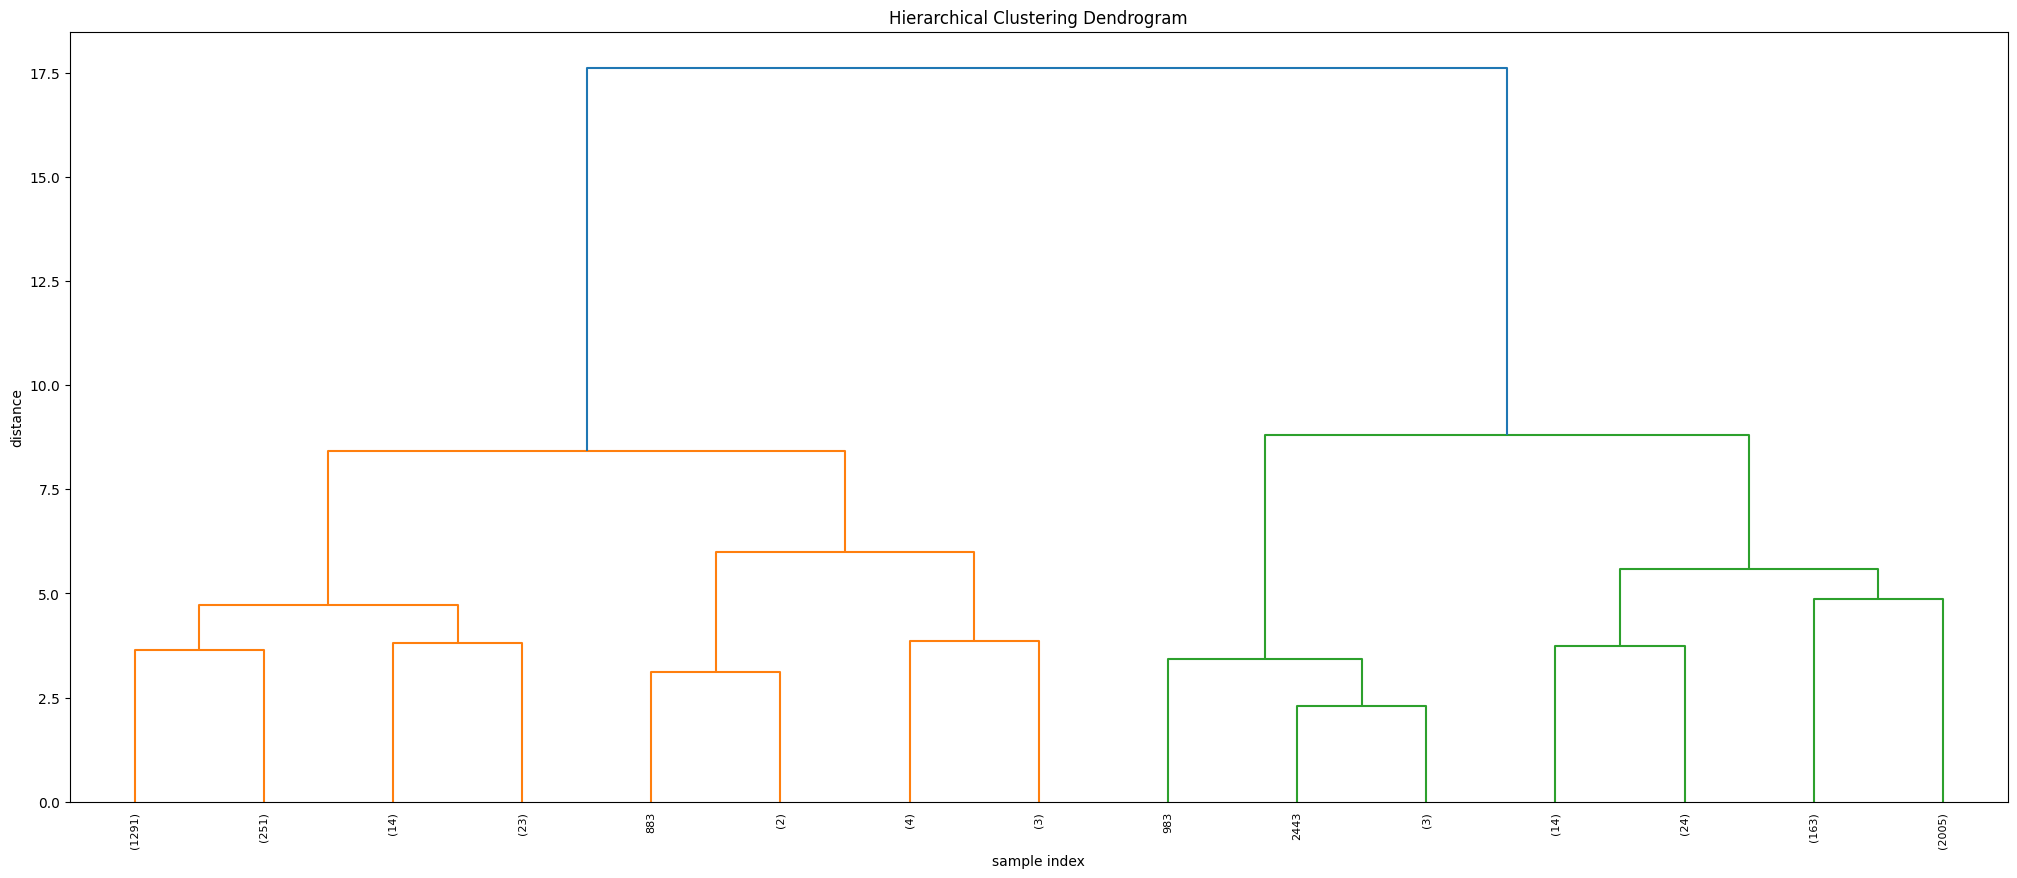

In [12]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    p=3,
    truncate_mode="level"
)
plt.show()